In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sn
import pandas as pd
import pickle
from collections import defaultdict
from sklearn import metrics
from torch.optim import lr_scheduler
from torchvision import datasets
import os

In [191]:
class Dataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][0]
        y = self.data[idx][1]
        
        if self.transform:
            x = self.transform(x)
        
        x = torch.Tensor(x)

        return (x, y)

from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/My Drive/COGS 181 Final Datasets/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [321]:
batch_size = 32
num_workers = 2

transform = transforms.Compose(
    [transforms.ToTensor(),])
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])




# GTZAN
GTZAN_data = pickle.load(open(drive_dir + 'GTZAN/GTZAN_165x32_normalized.train', 'rb'))
GTZAN_trainset = Dataset(GTZAN_data)
print(len(GTZAN_trainset))
GTZAN_trainloader = torch.utils.data.DataLoader(GTZAN_trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

GTZAN_data = pickle.load(open(drive_dir + 'GTZAN/GTZAN_165x32_normalized.test', 'rb'))
GTZAN_testset = Dataset(GTZAN_data)
GTZAN_testloader = torch.utils.data.DataLoader(GTZAN_testset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

GTZAN_classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']



# FMA
FMA_data = pickle.load(open(drive_dir + 'FMA/FMA_165x32_normalized.train', 'rb'))
FMA_trainset = Dataset(FMA_data)
print(len(FMA_trainset))
FMA_trainloader = torch.utils.data.DataLoader(FMA_trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

FMA_data = pickle.load(open(drive_dir + 'FMA/FMA_165x32_normalized.test', 'rb'))
FMA_testset = Dataset(FMA_data)
FMA_testloader = torch.utils.data.DataLoader(FMA_testset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

FMA_classes = ['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken']


# RAVDESS
RAVDESS_data = pickle.load(open(drive_dir + 'RAVDESS/RAVDESS_165x32_normalized.train', 'rb'))
RAVDESS_trainset = Dataset(RAVDESS_data)
print(len(RAVDESS_trainset))
RAVDESS_trainloader = torch.utils.data.DataLoader(RAVDESS_trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

RAVDESS_data = pickle.load(open(drive_dir + 'RAVDESS/RAVDESS_165x32_normalized.test', 'rb'))
RAVDESS_testset = Dataset(RAVDESS_data)
RAVDESS_testloader = torch.utils.data.DataLoader(RAVDESS_testset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

RAVDESS_classes = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful']#, 'disgust', 'surprised']

# Choose
trainloader = FMA_trainloader
testloader = FMA_testloader
classes = FMA_classes
num_classes = len(classes)

800
19988
809


In [322]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [0]:
# https://aip.scitation.org/doi/pdf/10.1063/1.5039095
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3,padding=1),
            nn.BatchNorm2d(64,momentum=0.1),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.Sigmoid(),
            nn.Conv2d(128, 256, kernel_size=3,padding=1),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=3,padding=1),
            nn.Sigmoid(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2)       
        )
   
        # flatten 
        self.fc = nn.Sequential(
            nn.Linear(512*2*10,1000),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(1000,100),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(100, num_classes),           
        )
        self.dropOut = nn.Dropout(0.1)
        
    def forward(self, x):

        x = self.main(x)
#         print ('x shape: ', x.shape)
        x = x.view(-1, 512*2*10) 
       
        x = self.fc(x) 
        x = self.dropOut(x)
        return x

In [324]:
# Initialize model
cnn = CNN()     # Create the network instance.
cnn.to(device)  # Move the network parameters to the specified device.

# Or Load model (Make sure num_classes is the correct size or this code will throw an error)
#cnn = CNN()
#cnn.to(device)
#cnn.load_state_dict(torch.load(drive_dir + 'Models/naivemodel_fma_50.m'))
#cnn.eval()

CNN(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Sigmoid()
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Sigmoid()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [0]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt_cnn = optim.Adam(cnn.parameters(), lr=0.001)#, momentum=0.9) 

In [256]:
torch.autograd.set_detect_anomaly(True)

In [257]:
avg_losses_cnn = []
avg_acc = []
epochs = 50       # Total epochs.
print_freq = len(trainloader)  # Print frequency.

try:
    for epoch in range(epochs):  # Loop over the dataset multiple times.
      # Initialize running loss.
        running_loss_cnn = 0.0 
        running_acc = 0.0
        cnn.train()

        for i, data in enumerate(trainloader):

            # Get the inputs.
            inputs, labels = data

            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients.

            opt_cnn.zero_grad()
                    
            outputs_cnn = cnn(inputs)
            _, preds = torch.max(outputs_cnn,1)
            loss_cnn = loss_func(outputs_cnn, labels)
            if loss_cnn < 0:
                print(outputs_cnn)
                print(labels)
                print(loss_cnn)
                assert()

            # Backward step.
            loss_cnn.backward()
            # Optimization step (update the parameters).
            opt_cnn.step()
            # Print statistics.         
            running_loss_cnn += loss_cnn.item()
            running_acc += torch.sum(preds == labels.data)
            if i % print_freq == print_freq - 1: # Print every several mini-batches.

                losses = running_loss_cnn / print_freq
                acc = running_acc / (print_freq*batch_size)

                print('[epoch: {}, i: {:5d}] avg mini-batch loss_cnn: {:.3f}, acc: {:.3f}'.format(
                    epoch, i, losses, acc))

                avg_losses_cnn.append(losses)
                avg_acc.append(acc)

                running_loss_cnn = 0.0
                running_acc = 0.0

    print('Finished Training.')
except KeyboardInterrupt:
    print('Halted Training')

[epoch: 0, i:    24] avg mini-batch loss_cnn: 2.296, acc: 0.146
[epoch: 1, i:    24] avg mini-batch loss_cnn: 2.059, acc: 0.278
[epoch: 2, i:    24] avg mini-batch loss_cnn: 1.880, acc: 0.343
[epoch: 3, i:    24] avg mini-batch loss_cnn: 1.803, acc: 0.340
[epoch: 4, i:    24] avg mini-batch loss_cnn: 1.724, acc: 0.381
[epoch: 5, i:    24] avg mini-batch loss_cnn: 1.623, acc: 0.441
[epoch: 6, i:    24] avg mini-batch loss_cnn: 1.579, acc: 0.454
[epoch: 7, i:    24] avg mini-batch loss_cnn: 1.531, acc: 0.455
[epoch: 8, i:    24] avg mini-batch loss_cnn: 1.482, acc: 0.469
[epoch: 9, i:    24] avg mini-batch loss_cnn: 1.413, acc: 0.532
[epoch: 10, i:    24] avg mini-batch loss_cnn: 1.488, acc: 0.480
[epoch: 11, i:    24] avg mini-batch loss_cnn: 1.380, acc: 0.515
[epoch: 12, i:    24] avg mini-batch loss_cnn: 1.379, acc: 0.509
[epoch: 13, i:    24] avg mini-batch loss_cnn: 1.281, acc: 0.555
[epoch: 14, i:    24] avg mini-batch loss_cnn: 1.311, acc: 0.537
[epoch: 15, i:    24] avg mini-batc

In [0]:
# Save Model
#torch.save(cnn.state_dict(), 'naivemodel_fma_100.m')

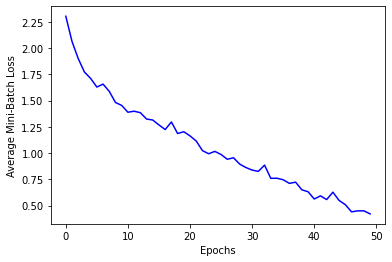

In [200]:
plt.plot(avg_losses_cnn, 'b')
#plt.plot(avg_losses_cnn, 'r', label='twitched')
#plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.xlabel('Epochs')
plt.ylabel('Average Mini-Batch Loss')
plt.show()

In [325]:
cnn = CNN()
cnn.to(device)
cnn.load_state_dict(torch.load(drive_dir + 'Models/naivemodel_fma_50.m'))
cnn.eval()

# Get test accuracy.
correct_net = 0
correct_cnn = 0
total = 0
with torch.no_grad():
    
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
#         outputs_net = net(images)
        outputs_cnn = cnn(images)
#         _, predicted_net = torch.max(outputs_net.data, 1)
        _, predicted_cnn = torch.max(outputs_cnn.data, 1)
        total += labels.size(0)
#         correct_net += (predicted_net == labels).sum().item()
        correct_cnn += (predicted_cnn == labels).sum().item()

# print('Net: Accuracy of the network on the 10000 test images: %d %%' % (
#     100 * correct_net / total))
print('Cnn: Accuracy of the network on the test images: %d %%' % (
    100 * correct_cnn / total))

Cnn: Accuracy of the network on the test images: 63 %


In [326]:
truths = []
preds = []

# Get test accuracy for each class.
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        #print(images.shape)
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        #print(len(outputs))
        c = (predicted == labels).squeeze()
        if type(c) is not list:
            c = [c]
        for i in range(batch_size):

            #assert()
            try:
              preds.append(predicted[i].item())
              
              truths.append(labels[i].item())

              label = labels[i]
              class_correct[label] += c[0][i]
              class_total[label] += 1
            except:
              pass

for i in range(num_classes):
    try:
        print(class_total[i])
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    except:
      pass
  

21.0
Accuracy of Blues :  0 %
133.0
Accuracy of Classical : 79 %
30.0
Accuracy of Country :  0 %
5.0
Accuracy of Easy Listening :  0 %
1304.0
Accuracy of Electronic : 76 %
442.0
Accuracy of Experimental : 48 %
289.0
Accuracy of  Folk : 66 %
443.0
Accuracy of Hip-Hop : 63 %
271.0
Accuracy of Instrumental : 36 %
221.0
Accuracy of International : 45 %
81.0
Accuracy of  Jazz :  0 %
98.0
Accuracy of Old-Time / Historic : 92 %
220.0
Accuracy of   Pop :  0 %
1384.0
Accuracy of  Rock : 78 %
29.0
Accuracy of Soul-RnB :  0 %
21.0
Accuracy of Spoken : 52 %


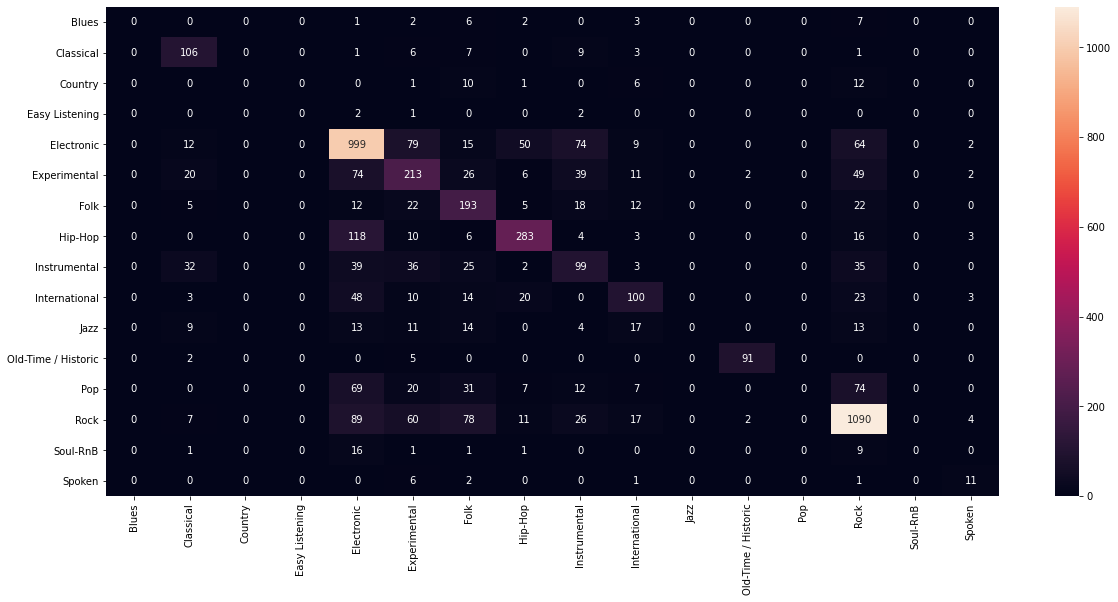

In [327]:
array = metrics.confusion_matrix([t - 1 for t in truths], [t - 1 for t in preds])
df_cm = pd.DataFrame(array, index = classes, columns = classes)
plt.figure(figsize = (20,9))
f = sn.heatmap(df_cm, annot=True, fmt='g')

figure = f.get_figure()    
figure.savefig('fma_before.png')

Transfer Learning:

In [309]:
# Choose main dataset
trainloader = FMA_trainloader
testloader = FMA_testloader
classes = FMA_classes
num_classes = len(classes)

cnn = CNN()
cnn.to(device)
cnn.load_state_dict(torch.load(drive_dir + 'Models/naivemodel_fma_50.m'))
cnn.eval()
model = cnn

# Choose second dataset
trainloader = RAVDESS_trainloader
testloader = RAVDESS_testloader
classes = RAVDESS_classes
num_classes = len(classes)
print(num_classes)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = 100

model_conv.fc = nn.Sequential(
            nn.Linear(512*2*10,1000),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(1000,100),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(100, num_classes),           
        )

cnn = model_conv

cnn = cnn.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt_cnn = optim.Adam(cnn.parameters(), lr=0.001)#, momentum=0.9) 

6


In [312]:
avg_losses_cnn = []
avg_acc = []
epochs = 50       # Total epochs.
print_freq = len(trainloader)  # Print frequency.

try:
    for epoch in range(epochs):  # Loop over the dataset multiple times.
      # Initialize running loss.
        running_loss_cnn = 0.0 
        running_acc = 0.0
        cnn.train()

        for i, data in enumerate(trainloader):

            # Get the inputs.
            inputs, labels = data

            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients.

            opt_cnn.zero_grad()
                    
            outputs_cnn = cnn(inputs)
            _, preds = torch.max(outputs_cnn,1)
            loss_cnn = loss_func(outputs_cnn, labels)
            if loss_cnn < 0:
                print(outputs_cnn)
                print(labels)
                print(loss_cnn)
                assert()

            # Backward step.
            loss_cnn.backward()
            # Optimization step (update the parameters).
            opt_cnn.step()
            # Print statistics.         
            running_loss_cnn += loss_cnn.item()
            running_acc += torch.sum(preds == labels.data)
            if i % print_freq == print_freq - 1: # Print every several mini-batches.

                losses = running_loss_cnn / print_freq
                acc = running_acc / (print_freq*batch_size)

                print('[epoch: {}, i: {:5d}] avg mini-batch loss_cnn: {:.3f}, acc: {:.3f}'.format(
                    epoch, i, losses, acc))

                avg_losses_cnn.append(losses)
                avg_acc.append(acc)

                running_loss_cnn = 0.0
                running_acc = 0.0

    print('Finished Training.')
except KeyboardInterrupt:
    print('Halted Training')

[epoch: 0, i:    24] avg mini-batch loss_cnn: 1.815, acc: 0.199
[epoch: 1, i:    24] avg mini-batch loss_cnn: 1.695, acc: 0.265
[epoch: 2, i:    24] avg mini-batch loss_cnn: 1.628, acc: 0.309
[epoch: 3, i:    24] avg mini-batch loss_cnn: 1.571, acc: 0.312
[epoch: 4, i:    24] avg mini-batch loss_cnn: 1.562, acc: 0.314
[epoch: 5, i:    24] avg mini-batch loss_cnn: 1.513, acc: 0.341
[epoch: 6, i:    24] avg mini-batch loss_cnn: 1.455, acc: 0.376
[epoch: 7, i:    24] avg mini-batch loss_cnn: 1.471, acc: 0.365
[epoch: 8, i:    24] avg mini-batch loss_cnn: 1.425, acc: 0.391
[epoch: 9, i:    24] avg mini-batch loss_cnn: 1.431, acc: 0.395
[epoch: 10, i:    24] avg mini-batch loss_cnn: 1.423, acc: 0.373
[epoch: 11, i:    24] avg mini-batch loss_cnn: 1.407, acc: 0.394
[epoch: 12, i:    24] avg mini-batch loss_cnn: 1.398, acc: 0.407
[epoch: 13, i:    24] avg mini-batch loss_cnn: 1.389, acc: 0.419
[epoch: 14, i:    24] avg mini-batch loss_cnn: 1.364, acc: 0.421
[epoch: 15, i:    24] avg mini-batc

In [313]:
# Get test accuracy.
correct_net = 0
correct_cnn = 0
total = 0
with torch.no_grad():
    
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
#         outputs_net = net(images)
        outputs_cnn = cnn(images)
#         _, predicted_net = torch.max(outputs_net.data, 1)
        _, predicted_cnn = torch.max(outputs_cnn.data, 1)
        total += labels.size(0)
#         correct_net += (predicted_net == labels).sum().item()
        correct_cnn += (predicted_cnn == labels).sum().item()

# print('Net: Accuracy of the network on the 10000 test images: %d %%' % (
#     100 * correct_net / total))
print('Cnn: Accuracy of the network on the test images: %d %%' % (
    100 * correct_cnn / total))

Cnn: Accuracy of the network on the test images: 56 %


In [314]:
truths = []
preds = []

# Get test accuracy for each class.
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        #print(images.shape)
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        #print(len(outputs))
        c = (predicted == labels).squeeze()
        if type(c) is not list:
            c = [c]
        for i in range(batch_size):

            #assert()
            try:
              preds.append(predicted[i].item())
              
              truths.append(labels[i].item())

              label = labels[i]
              class_correct[label] += c[0][i]
              class_total[label] += 1
            except:
              pass

for i in range(num_classes):
    try:
        print(class_total[i])
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    except:
      pass

20.0
Accuracy of neutral : 45 %
39.0
Accuracy of  calm : 64 %
30.0
Accuracy of happy : 63 %
37.0
Accuracy of   sad : 40 %
35.0
Accuracy of angry : 51 %
31.0
Accuracy of fearful : 51 %


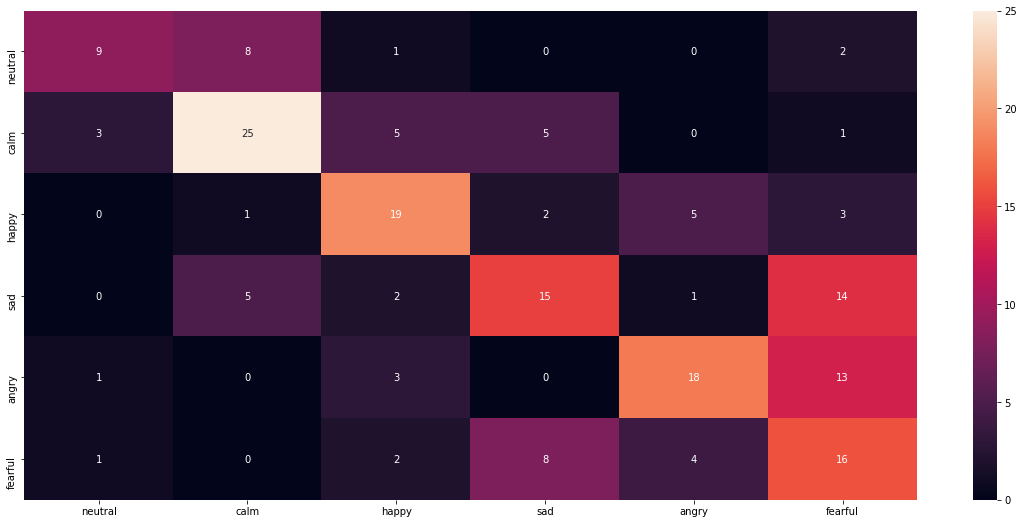

In [316]:
array = metrics.confusion_matrix(truths, preds)
df_cm = pd.DataFrame(array, index = classes, columns = classes)
plt.figure(figsize = (20,9))
f = sn.heatmap(df_cm, annot=True, fmt='g')

figure = f.get_figure()    
figure.savefig('ravdess_after.png')